# Source Code

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers, losses
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data

## Load Data

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


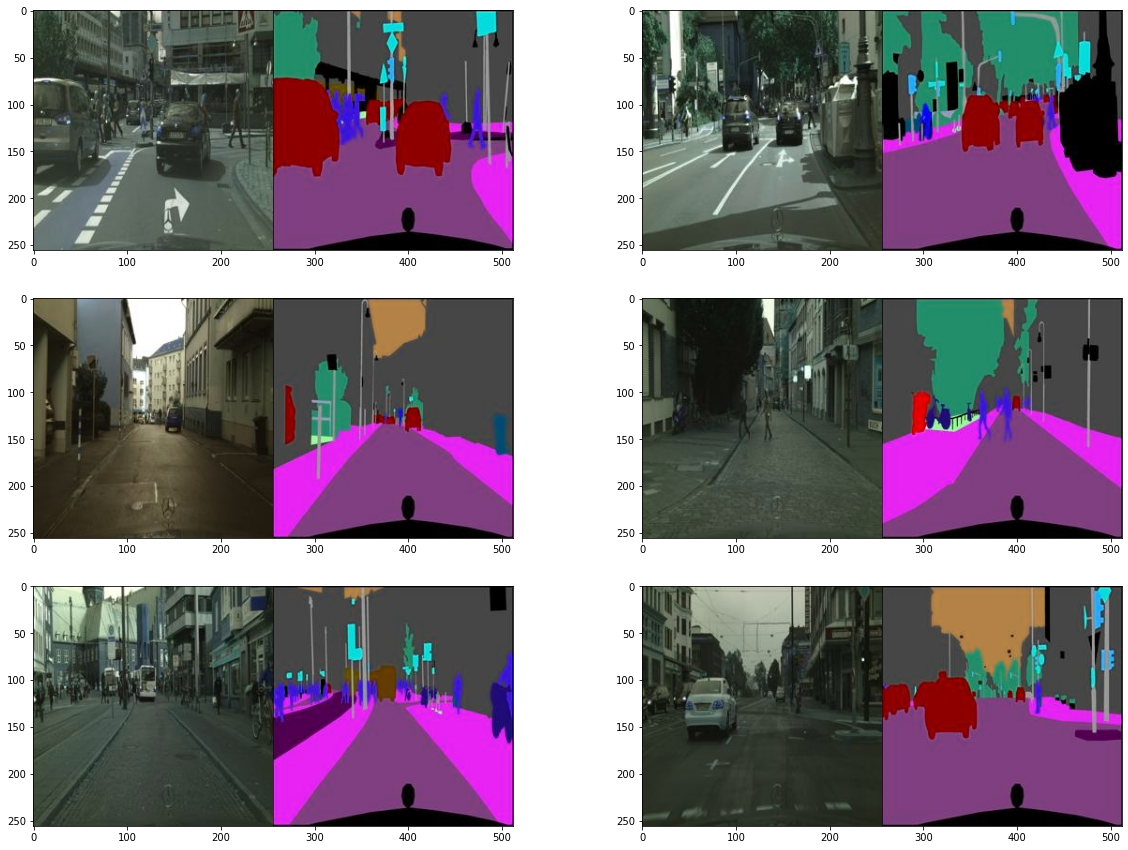

In [3]:
plt.figure(figsize=(20,15))

for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print("Shape of image:", img.shape)

Shape of image: (256, 512, 3)


- (256 x 256) 의 두 이미지가 가로로 붙어있는 Shape 입니다.
<br>
<br>
- 왼쪽 이미지는 real_image, 오른쪽 이미지는 Semantic Map 이므로 Pix2Pix 의 input_image 로 사용하겠습니다.

## Data Preprocessing

In [6]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    
    return (x / 127.5) - 1

In [8]:
def denormalize(x):
    x = (x + 1) * 127.5
    x = x.numpy()
    
    return x.astype(np.uint8)

In [25]:
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_map = img[:, :w, :] 
    real_map = tf.cast(real_map, tf.float32)
    semantic_map = img[:, w:, :] 
    semantic_map = tf.cast(semantic_map, tf.float32)
    
    return normalize(real_map), normalize(semantic_map)

In [26]:
@tf.function()
def apply_augmentation(real_map, semantic_map):
    stacked = tf.concat([real_map, semantic_map], axis=-1)

    out = image.random_crop(stacked, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   


In [27]:
def get_train(img_path):
    real_map, semantic_map = load_img(img_path)
    real_map, semantic_map = apply_augmentation(real_map, semantic_map)
    
    return real_map, semantic_map

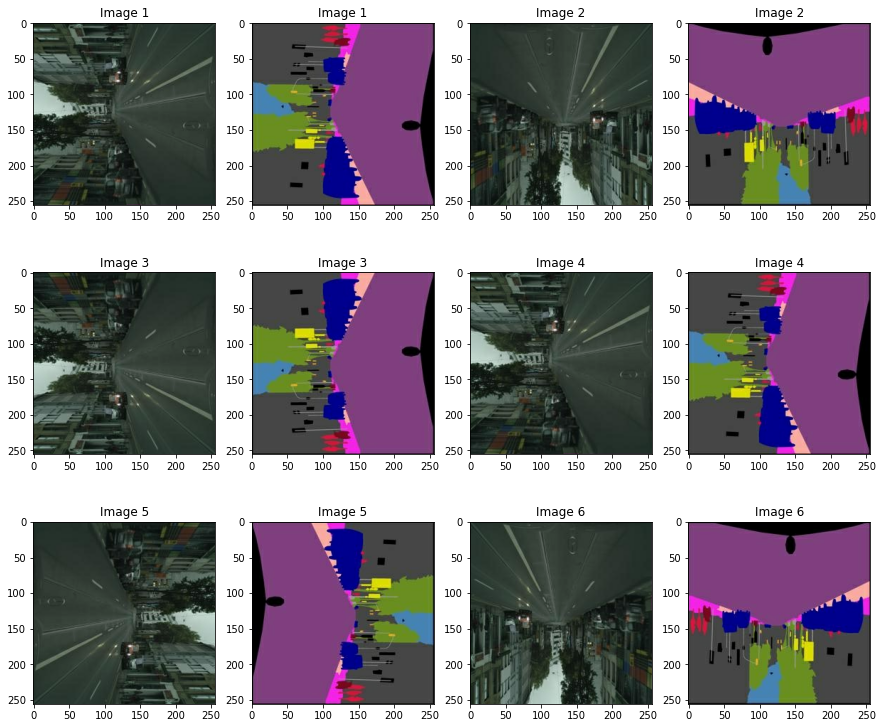

In [18]:
plt.figure(figsize=(15, 13))
img_n = 1

for i in range(1, 13, 2):
    augmented_real_map, augmented_semantic_map = apply_augmentation(real_map, semantic_map)
    
    plt.subplot(3, 4, i)
    plt.imshow(denormalize(augmented_real_map)); plt.title(f"Image {img_n}")
    plt.subplot(3, 4, i+1); 
    plt.imshow(denormalize(augmented_semantic_map)); plt.title(f"Image {img_n}")
    img_n += 1

- (256, 256, 6) Shape 의 이미지를 임의로 Crop 하고, 50% 확률로 가로/세로 기준 Flip 합니다.
<br>
<br>
- 위의 결과를 50% 확률로 Rotate 합니다.

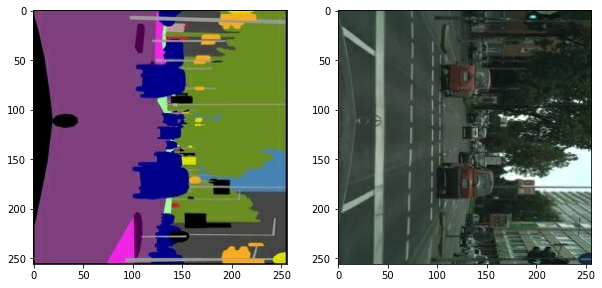

In [29]:
train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
real_map, semantic_map = (sample[0][0] + 1) * 127.5, (sample[0][1] + 1) * 127.5

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1); plt.imshow(semantic_map[0].astype(np.uint8))
plt.subplot(1, 2, 2); plt.imshow(real_map[0].astype(np.uint8))

## Modeling

### U-Net Generator(Encoder)

In [30]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        x = self.lrelu(x)

        return x

### U-Net Generator(Decoder)

In [33]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)    
        x = self.relu(x)
        
        return x

### U-Net Generator(Model)

In [36]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64, 128, 256, 512, 512, 512, 512, 512]
        decode_filters = [512, 512, 512, 512, 256, 128, 64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        
        return Model(inputs, self.call(inputs)).summary()

In [37]:
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_8 (EncodeBlock)    (None, 128, 128, 64) 3072        input_3[0][0]                    
__________________________________________________________________________________________________
encode_block_9 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block_8[0][0]             
__________________________________________________________________________________________________
encode_block_10 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_9[0][0]             
____________________________________________________________________________________________

### PatchGAN Discriminator(Model)

In [39]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
            
        return x 

In [46]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        filters = [64, 128, 256, 512, 1]
        
        self.block1 = layers.Concatenate()
        self.blocks = []
        for i, f in enumerate(filters):
            self.blocks.append(DiscBlock(
                                n_filters=f,
                                stride=2 if i<3 else 1,
                                custom_pad=False if i<3 else True,
                                use_bn=False if i==0 and i==4 else True,
                                act=True if i<4 else False
                            ))
            
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        
        for block in self.blocks:
            out = block(out)
        
        out = self.sigmoid(out)
        
        return out
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape)
        
        return Model((x, y), self.call(x, y)).summary()

In [47]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block_10 (DiscBlock)       (None, 128, 128, 64) 6400        concatenate_10[0][0]       

## Loss Function

### Loss

In [48]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

In [49]:
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    
    return gene_loss, l1_loss

In [50]:
def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

### Optimizer

In [51]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

## Training

In [52]:
@tf.function
def train_step(semantic_map, real_map):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_real_map = generator(semantic_map, training=True)
        
        # Discriminator 예측
        fake_disc = discriminator(semantic_map, fake_real_map, training=True)
        real_disc = discriminator(semantic_map, real_map, training=True)
        
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_real_map, real_map, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

In [ ]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))